# 0.3 BP Model in Tensorflow

## Boilerplate

The following subsections are largely boilerplate code, so skip around as needed.

### Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn,tensorflow

Sun Mar 03 2019 01:37:24 

CPython 3.6.8
IPython 7.3.0

numpy 1.16.2
matplotlib 3.0.3
seaborn 0.9.0
tensorflow 1.12.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.4.0-130-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit
Git hash   : edd22d45c1c38e765037bf04d03c4caf4494dc66
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

### Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [20]:
# Standard library imports
import os
import logging
from functools import reduce

# Third party
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models, layers, initializers, optimizers
from tqdm import tqdm

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [41]:
# Task script
%aimport leabratf.tasks.combinatorics.combigen
import leabratf.tasks.combinatorics.combigen as cg
# Visualization for the task
%aimport leabratf.visualization.combigen_heatmap
import leabratf.visualization.combigen_heatmap as cgh
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging
%aimport leabratf.constants
from leabratf.constants import DIR_MODELS

### Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [6]:
sns.set()
sns.set_context("notebook")

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [45]:
# Run base logger setup
# setup_logging()
# Define a logger object
logger = logging.getLogger('leabratf')
# Don't propagate messages
logger.propagate = False

tf.logging.set_verbosity(logging.INFO)

### Global Variables

#### Combigen Task Variables

In [9]:
# Number of slots in a training set
STACK = 4
# Size of each axis in the input array
SIZE = 5
# Number of axes to use per slot
DIMS = 2

#### Data Parameters

In [10]:
# Number of epochs to train for
EPOCHS = 500
# Number of samples in the training set
N_TRAIN= 100
# Number of samples in the validation set
N_VAL = 50
# Number of samples in the testing set
N_TEST = 500

#### Datasets

In [11]:
# Training Data
Y_TRAIN = cg.generate_labels(n_samples=N_TRAIN, stack=STACK, size=SIZE, dims=DIMS)
X_TRAIN = cg.inverse_transform(Y_TRAIN)
# Validation Data
Y_VAL = cg.generate_labels(n_samples=N_VAL, stack=STACK, size=SIZE, dims=DIMS)
X_VAL = cg.inverse_transform(Y_VAL)
# Testing data
Y_TEST = cg.generate_labels(n_samples=N_TEST, stack=STACK, size=SIZE, dims=DIMS)
X_TEST = cg.inverse_transform(Y_TEST)

#### Network Parameters

In [12]:
# Learning rate
ALPHA = 0.01
# Batch size
BATCH_SIZE = 1
# Number of parameters in the inputs
N_INPUTS = STACK * SIZE ** DIMS
# Number of hidden units
N_HIDDEN_1 = 100
# Number of parameters in the labels
N_OUTPUTS = STACK * SIZE * DIMS

## Background

This section goes over some of the background information for the notebook using results from previous notebooks. Skip around as needed.

### The Combigen Task

Quickly remind ourselves what the task looks like before diving in.

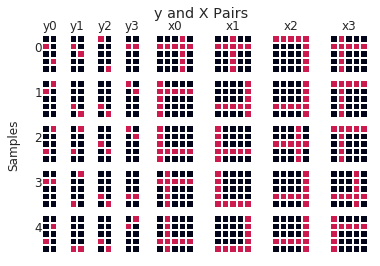

In [13]:
cgh.visualize_combigen(5)
plt.show()

### Keras Implementation

In nb-0.2.x, the O'Reilly BP model was implemented in keras with the code having this general structure:

```
def bp_model_bce(hidden_units=100, stack=STACK, size=SIZE, dims=DIMS):
    """Builds and returns the model"""
    model = models.Sequential()
    model.add(layers.Reshape((stack*size*size,), name='Initial_reshape'))
    # Single hidden layer
    model.add(layers.Dense(hidden_units, activation='sigmoid', name='Hidden_Layer'))
    # Output layer
    model.add(layers.Dense(stack*size*dims, activation='sigmoid', name='Output_Layer'))
    # Reshape to match the labels
    model.add(layers.Reshape((stack, size, dims), name='Output_reshape'))
    
    # Loss and optimizer to use, along with metrics to track
    model.compile(optimizer=optimizers.SGD(lr=0.01), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model
```

With the main difference between models tested in nb-0.2.1 being the loss functions. The two most interesting models had the following training curves:

**Binary cross-entropy loss with stochastic gradient descent**


![BCE_SGD](images/nb0.2.1_bce_sgd_5000_epochs.png)


**Mean-squared-error loss with stochastic gradient descent**


![MSE_SGD](images/nb0.2.1_mse_sgd_5000_epochs.png)


Some things to note are that the models were trained to 10 times the number of epochs as O'Reilly did (500). However, a dotted vertical line was added at the 500 epoch mark to make it clear what the model's performance would have looked like.

## Tensorflow Estimator

Using the results of the keras implementation as the benchmark for this model, let's rewrite the model using the estimator API and pure tensorflow. Let's start by defining the weights and associated biases.

### Input_fn

In [15]:
# Training input fn
input_fn_train = tf.estimator.inputs.numpy_input_fn(
    x={'inputs': X_TRAIN}, y=Y_TRAIN, batch_size=BATCH_SIZE, 
    num_epochs=EPOCHS, shuffle=True)

# Testing input fn
input_fn_test = tf.estimator.inputs.numpy_input_fn(
    x={'inputs': X_TEST}, y=Y_TEST, batch_size=BATCH_SIZE, shuffle=False)

### O'Reilly Model

In [46]:
def oreilly_model(inputs):
    # Grab the data from the data dict
    x = inputs['inputs']
    # Reshape for hidden layer
    x = tf.reshape(x, shape=[-1, N_INPUTS])
    # Single hidden layer
    x = tf.layers.dense(x, N_HIDDEN_1, activation='sigmoid')
    # Output layer
    x = tf.layers.dense(x, N_OUTPUTS, activation='sigmoid')
    # Reshape for labels
    return tf.reshape(x, shape=[-1, STACK, SIZE, DIMS])

In [47]:
def oreilly_model_fn(features, labels, mode):
    # Build the model
    logits = oreilly_model(features)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=logits)
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=logits, labels=tf.cast(labels, tf.float32)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=ALPHA)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    accuracy_op = tf.metrics.accuracy(labels=labels, predictions=logits)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=logits,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': accuracy_op})

    return estim_specs

In [48]:
# Build the Estimator
model = tf.estimator.Estimator(oreilly_model_fn, model_dir=DIR_MODELS)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/home/abdullah_rashed/work/projects/leabra-tf/models', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7b35b636a0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [49]:
%%time
long_train_fn = input_fn_train
long_train_fn.num_epochs = 10*EPOCHS
model.train(long_train_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/abdullah_rashed/work/projects/leabra-tf/models/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 50000 into /home/abdullah_rashed/work/projects/leabra-tf/models/model.ckpt.
INFO:tensorflow:loss = 0.69327646, step = 50000
INFO:tensorflow:global_step/sec: 317.498
INFO:tensorflow:loss = 0.6951164, step = 50100 (0.318 sec)
INFO:tensorflow:global_step/sec: 399.515
INFO:tensorflow:loss = 0.7085766, step = 50200 (0.249 sec)
INFO:tensorflow:global_step/sec: 383.33
INFO:tensorflow:loss = 0.70331746, step = 50300 (0.261 sec)
INFO:tensorflow:global_step/sec: 393.938
INFO:tensorflow:loss = 0.70301396, step = 50400 (0.254 sec)
INFO:tensorflow:global_step/sec: 432.651
INFO:tensorflow:loss = 0.69799423, step = 5050

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/abdullah_rashed/work/projects/leabra-tf/models/model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


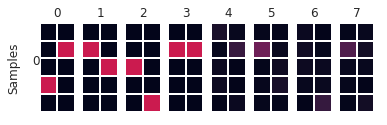

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/abdullah_rashed/work/projects/leabra-tf/models/model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


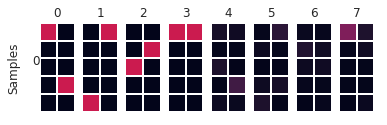

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/abdullah_rashed/work/projects/leabra-tf/models/model.ckpt-100000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


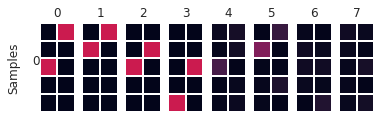

In [50]:
def visualize_model(model, n_tests=3):
    for _ in range(n_tests):
        visualization_y = cg.generate_labels()
        visualization_x = cg.inverse_transform(visualization_y)
        input_fn = tf.estimator.inputs.numpy_input_fn(
            x={'inputs': visualization_x}, y=visualization_x, 
            batch_size=BATCH_SIZE, shuffle=False)
        predicted_y = np.array(list(model.predict(input_fn)))
        cgh.heatmap(visualization_y, predicted_y)
        plt.show()

visualize_model(model)

In [53]:
model.get_variable_value('accuracy_op')

NotFoundError: Key accuracy_op not found in checkpoint